In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit, prange
from numba import types
from scipy.optimize import curve_fit
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import matplotlib.cm as cm

COLOR = "black"
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams["figure.figsize"] = (28, 18)
rcParams["figure.titlesize"] = 20
rcParams["figure.dpi"] = 50
rcParams["axes.grid"] = True
# rcParams["axes.facecolor"] = "lightgray"  # Disgusting -Agus. :( -Arcus
rcParams["legend.fontsize"] = 25
rcParams["axes.titlesize"] = 60
rcParams["axes.labelsize"] = 50
rcParams["ytick.labelsize"] = 20
rcParams["xtick.labelsize"] = 20
rcParams["text.color"] = COLOR
rcParams["text.color"] = COLOR
rcParams["axes.labelcolor"] = COLOR
rcParams["xtick.color"] = COLOR
rcParams["ytick.color"] = COLOR
rcParams["grid.color"] = COLOR
rcParams["text.latex.preamble"] = "\n".join([r"\usepackage[version=3]{mhchem}"])

### Definiciones pre-simulación

In [3]:
@njit  # Para que numba compile la función
def h(S):  # Calcula la energía de la red en   el estado S
    H = 0
    for i in np.arange(S.shape[0]):
        for j in np.arange(S.shape[1]):
            H += -S[i, j] * (S[i - 1, j] + S[i, j - 1])
    return H / S.size
    # Aca S.size ya nos dá la normalización por L^2


@njit
def calculate_dE(sij, i, j, S):
    # xx s3 xx
    # s4 s0 s2
    # xx s1 xx
    L = S.shape[0]
    upper_i, upper_j = (i + 1) % L, (
        j + 1
    ) % L  # Si i+1 = L -> (i+1)%L=0, esto fuerza cc periódicas
    s1, s2, s3, s4 = S[upper_i, j], S[i, upper_j], S[i - 1, j], S[i, j - 1]
    return 2 * sij * (s1 + s2 + s3 + s4)


@njit
def metropolis(S, prob):  # Aplica el algoritmo de Metropolis al estado S
    dm = 0
    de = 0

    for n in range(S.size):
        i, j = np.random.choice(
            S.shape[0], 2
        )  # Elegimos 2 posiciones al azar en el rango [0,L)
        sij = S[i, j]  # Obtenemos el spin de esa posición
        opp_sij = -sij  # Obtenemos el spin opuesto al original
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía entre tener el spin opuesto y tener el actual
        p = np.random.random(1)

        if (
            dE_sij <= 0
            or (dE_sij == 4 and p < prob[0])
            or (dE_sij == 8 and p < prob[1])
        ):
            S[i, j] = opp_sij
            de += dE_sij
            dm += opp_sij
        # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en
        # la red, es decir, L cuadrado veces.
    return S, dm / S.size, de / S.size

### Simulación

In [7]:
L = 64  # Dimensiones de la red
S = np.ones((L, L), dtype=int)
# S = 2*np.random.randint(2,size=(L,L))-1 # Red de -1y1 bidimensional
T = 2.27
beta = 1 / T
dE = np.array([4, 8])  # únicos Delta_E positivos
prob = np.exp(-beta * dE)

Neq = 10_000  # Nro de pasos para el equilibrio
M = np.zeros(Neq)  # Magnetización en función del paso
E = np.zeros(Neq)  # Energía por particula en funcion del paso
M[0] = np.mean(S)  # Promedio de spines
E[0] = h(S)  # Energía por partícula

Mbar = np.zeros_like(M)
Ebar = np.zeros_like(E)

Mbar[0] = np.mean(abs(M[0]))
Ebar[0] = E[0]

average_counter = 0

for n in tqdm(range(1, Neq)):
    #S, E_new, M_new = metropolis(S, prob, 0)
    S, dm, de = metropolis(S, prob)
    M[n] = M[n - 1] + dm
    E[n] = E[n - 1] + de
    Mbar[n] = np.mean(abs(M[:n+1]))
    Ebar[n] = np.mean(E[:n+1])
    
    #Si la diferencia absoluta entre este paso y el siguiente es menor a 10e-6 añado uno al contador de promedio
    #Si esto sucede 500 veces decimos que el sistema tiene un promedio estable
    if abs(Ebar[n-1]-Ebar[n])<1e-6:
        average_counter+=1
    if average_counter==500:
        break

Enn = E[np.where(E!=0)]
Mnn = M[np.where(M!=0)]
Ebar = Ebar[np.where(E!=0)]
Mbar = Mbar[np.where(Mbar!=0)]

  0%|          | 0/9999 [00:00<?, ?it/s]

### Gráficos

<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2354918/3215594579.py:9: SyntaxWarning: invalid escape sequence '\o'
  ax1.plot(Ebar, color="tab:green", label="$\overline{E}$", lw=3)
/tmp/ipykernel_2354918/3215594579.py:12: SyntaxWarning: invalid escape sequence '\o'
  ax2.plot(Mbar, color="violet", label="$\overline{M}$", lw=3)


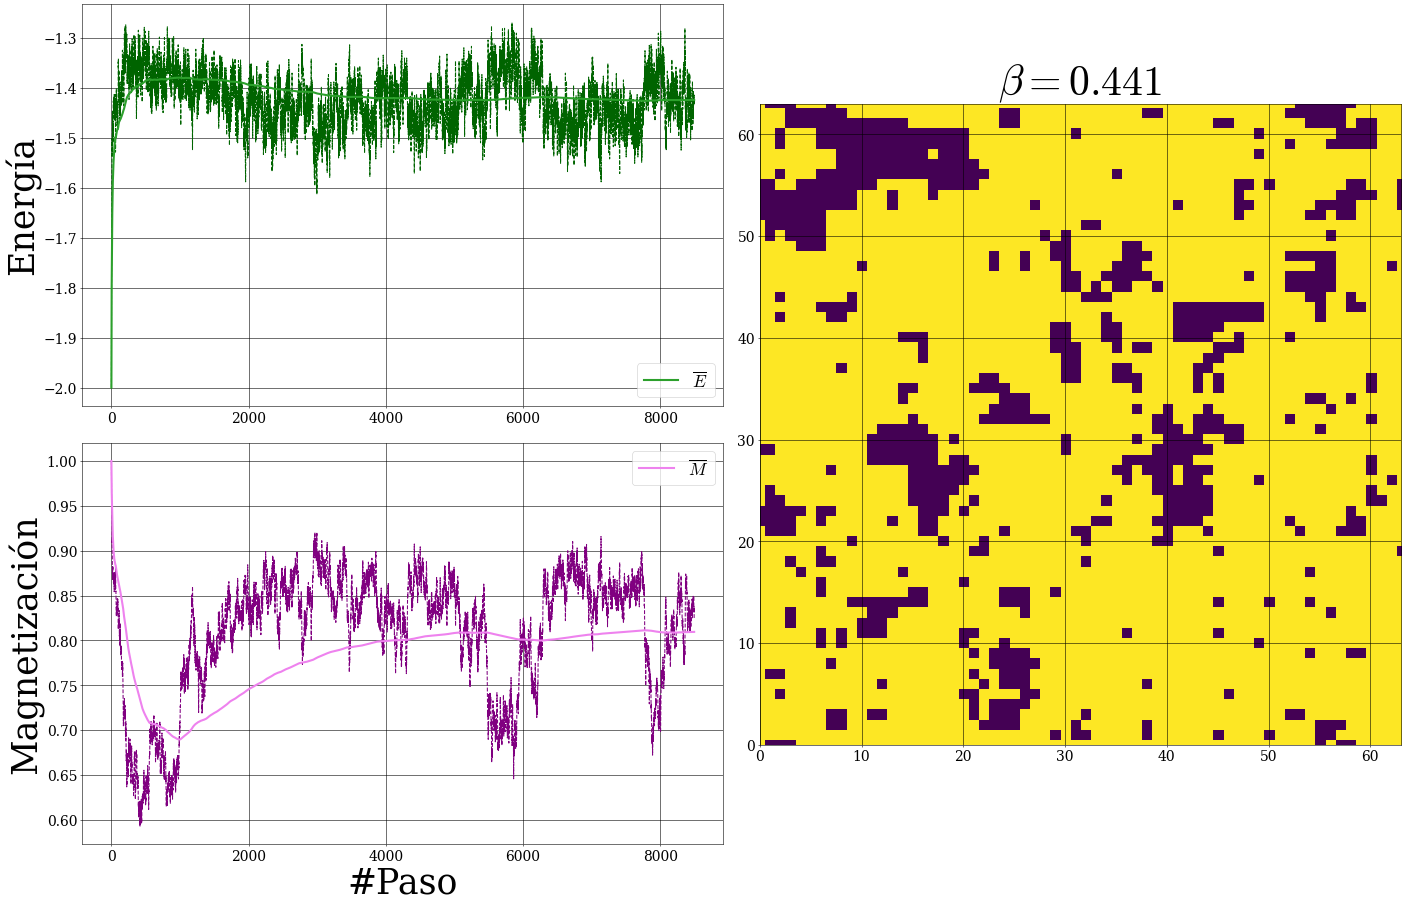

In [8]:
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax_2d = fig.add_subplot(gs[:, 1])

ax1.plot(Enn, color="darkgreen", linestyle='--')
ax1.plot(Ebar, color="tab:green", label="$\overline{E}$", lw=3)

ax2.plot(Mnn, color="purple", linestyle='--')
ax2.plot(Mbar, color="violet", label="$\overline{M}$", lw=3)

ax_2d.imshow(S)

ax_2d.set_ylim(0, L - 1)
ax_2d.set_xlim((0, L - 1))


ax1.set_ylabel("Energía")
ax2.set_ylabel("Magnetización")
ax2.set_xlabel("#Paso")
ax_2d.set_title(f"$\\beta = {beta:.3g}$")

ax1.legend()
ax2.legend()

# Estudio de las variaciones de los promedios en función de T y L

In [4]:
def create_dense_domain_around_tc(Tc, number_of_points):

    # Define the range of the domain
    x_min = 0.5
    x_max = Tc*2 - 0.5

    # Number of points to generate

    # Define the density function (a Gaussian-like distribution)
    def density_function(x, center, scale):
        return np.exp(-((x - center) ** 2) / (2 * scale ** 2))

    # Generate x values
    x_values = np.linspace(x_min, x_max, number_of_points)

    # Compute the density values
    scale = 0.5  # Adjust scale for desired density spread
    density_values = density_function(x_values, Tc, scale)

    # Normalize the density values
    density_values /= np.sum(density_values)

    # Create a cumulative distribution function (CDF) for the density values
    cdf = np.cumsum(density_values)

    # Generate the dense domain using the inverse CDF method
    dense_domain = np.interp(np.linspace(0, 1, number_of_points), cdf, x_values)
    return dense_domain

@njit
def termalize_S(S, prob):
    n = 0
    n_check = 100
    historic_de = np.zeros(n_check)
    while True:
        S, _, de = metropolis(S, prob)
        historic_de[n%n_check] = de
        
        n+=1
        sum_de = np.sum(historic_de)
        if n//n_check>0:
            if np.abs(sum_de/(n_check)) < 1e-6:
                break        
    return S

@njit
def do_sim_until_stable(E0,M0,S, prob):
    Ebar = E0
    Mbar = M0
    N_check=500
    n = 0
    while True:
        S, dm, de = metropolis(S, prob)
        Ebar[(n+1)%N_check] = (Ebar[n%N_check] + de)/N_check
        Mbar[(n+1)%N_check] = np.abs((Mbar[n%N_check] + dm))/N_check

        # Si llené los N_check valores de mis arrays de E y M promedio
        if n//N_check>0:
            if (np.abs(Ebar[-1] - Ebar[0]) < 1e-3) and (np.abs(Mbar[-1] - Mbar[0]) < 1e-3):
                break
        n+=1
    return n


def get_stable_ns_for_measurement(L_arr, T_arr):
    LT_matrix = np.zeros((L_arr.size, T_arr.size))
    N_check = 500

    for li,L in enumerate(L_arr):
        S0 = [np.ones((L, L), dtype=int), 2*np.random.randint(2,size=(L,L))-1]
        for ti,T in enumerate(T_arr):
            beta = 1 / T
            prob = np.exp(-beta * dE)
            if T < 2.27:
                S = S0[0] #T bajas
            else:
                S = S0[1] #T altas
            S = termalize_S(S, prob)
            Mbar = np.zeros(N_check)
            Ebar = np.zeros(N_check)

            Mbar[0] = np.sum(S)/S.size
            Ebar[0] = h(S)
            LT_matrix[li,ti] = do_sim_until_stable(Ebar, Mbar,S, prob)
    return LT_matrix

In [5]:
T_arr = create_dense_domain_around_tc(2.27, 50)
L_arr = np.array([2**n for n in range(4,8+1)]) # de 16 a 256
dE = np.array([4, 8])  # únicos Delta_E positivos

df_n = pd.DataFrame(index = T_arr, columns= [*L_arr])
LT_matrix = np.zeros((L_arr.size, T_arr.size))
for i in tqdm(range(10)):
    LT_matrix+=get_stable_ns_for_measurement(L_arr, T_arr)

LT_matrix = np.round(LT_matrix/10)

for ti,t in enumerate(T_arr):
    for li,l in enumerate(L_arr):
        df_n.loc[t,l] = LT_matrix[li,ti]

df_n.to_csv('LT_matrix.csv')

  0%|          | 0/10 [03:54<?, ?it/s]


SystemError: CPUDispatcher(<function termalize_S at 0x7d5a394b3490>) returned a result with an exception set

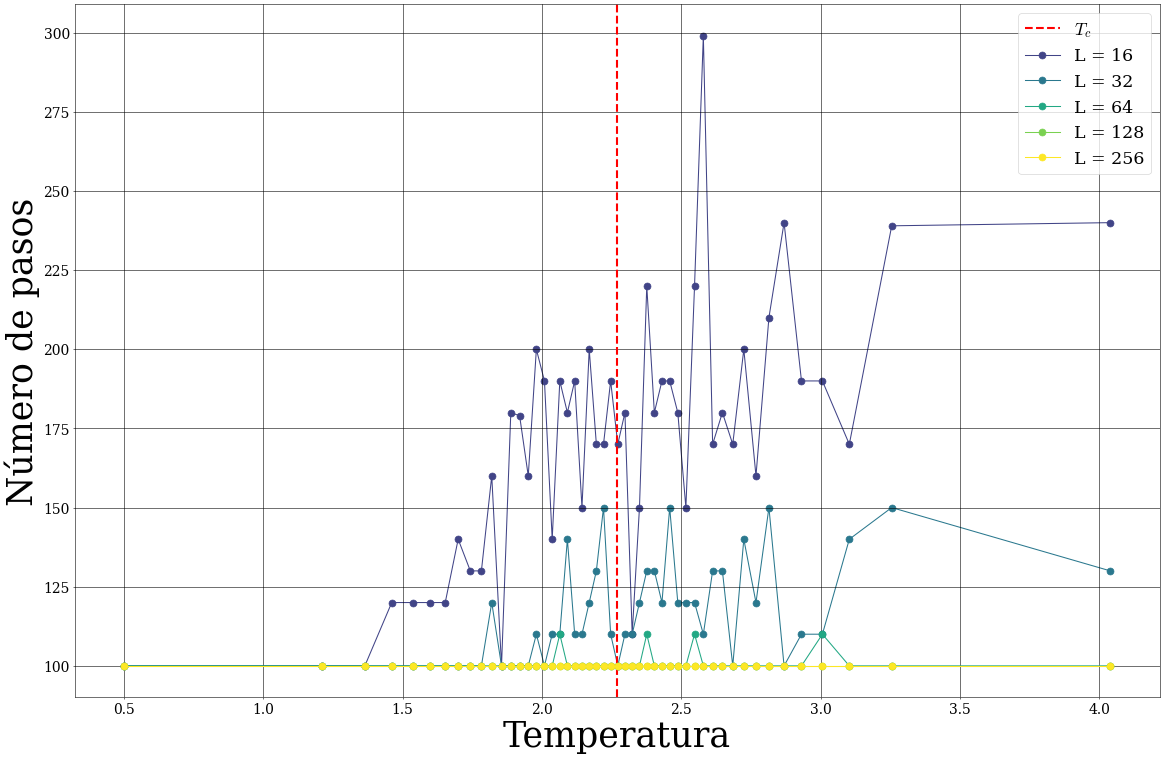

In [18]:
fig,ax = plt.subplots()
ax.axvline(2.27, color='r', ls='--', lw=3, label='$T_c$')
for li,L in enumerate(L_arr):
    ax.plot(T_arr, LT_matrix[li,:], '-o', markersize=10, label=f'L = {L}', color = cm.viridis((li+1)/5), zorder=li)
    ax.set_ylabel('Número de pasos')
    ax.set_xlabel('Temperatura')
    ax.legend()

# Transición de fase

### Consigna: 
Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de unos, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de unos y menos unos.
*   Conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.

Aquí se muestran unos gráficos tìpicos. El de la susceptibilidad puede mejorarse.

![tipicos](http://materias.df.uba.ar/ft3a2024c1/files/2024/06/tipicos.png)

### Notas para punto 3: Transición de fase

Formulas del apunte de Minnini: 

- $\langle \Delta E ^ 2 \rangle = k T^2 N c_v$

- $\langle \Delta M ^ 2 \rangle = k T N \chi$

### Comentarios para mi

- Lo importante es entender dónde tomo el promedio y cómo lo tomo:
    1) Termalizar 
    2) Una vez que haya termalizado tomar $N$ puntos a partir de ahí para tomar el promedio y desvio
    
- A priori mi idea es ahora escribir el código haciendo esos calculos eligiendo los últimos puntos desde algún lugar en particular y después ser más rigurosa
- Establecí medio a mano lo de establecer cuales son 'temperaturas bajas' y 'temperaturas altas'

- Me falta:
    1) Hacer lo de tener menos pasos (lo del S inicial tomar el de la temperatura anterior) [LISTO PERO DESPROLIJO]
    2) Chequear que termaliza (espero a resultados de arcus)
    3) Criterio T alta y T baja (preguntar en clase tal vez)

In [23]:
@njit
def doNstepsofSimulation(S,N,prob):
    M = np.zeros(N)  # Magnetización en función del paso
    E = np.zeros(N)  # Energía por particula en funcion del paso
    M[0] = np.sum(S)/S.size  # Promedio de spines
    E[0] = h(S)  # Energía por partícula

    for n in range(1, N):
        S, dm, de = metropolis(S, prob)
        M[n] = M[n - 1] + dm
        E[n] = E[n - 1] + de

    return E,M

@njit
def getStermalized(S, prob):
    n = 0
    n_check = 100
    historic_de = np.zeros(n_check)
    while True:
        S, _, de = metropolis(S, prob)
        historic_de[n%n_check] = de
        
        n+=1
        sum_de = np.sum(historic_de)
        if n//n_check>0:
            if np.abs(sum_de/(n_check)) < 1e-6:
                break        
    return S

@njit
def phase_transition(T, N, n_stable, S0):
    beta = 1 / T
    dE = np.array([4, 8])  # únicos Delta_E positivos
    prob = np.exp(-beta * dE)

    #Termalizamos el sistema
    S = getStermalized(S0, prob)
    #Lo estabilizamos
    E,M = doNstepsofSimulation(S,n_stable,prob)
    #Tomamos N muestras de la energía y la magnetización
    E,M = doNstepsofSimulation(S,N,prob)
    
    avg_E = np.sum(E)/N
    avg_M = np.sum(np.abs(M))/N

    std_E = np.sqrt(np.sum((E - avg_E)**2)/(N-1))
    std_M = np.sqrt(np.sum((np.abs(M) - avg_M)**2)/(N-1))

    return avg_E, avg_M, std_E**2, std_M**2, S


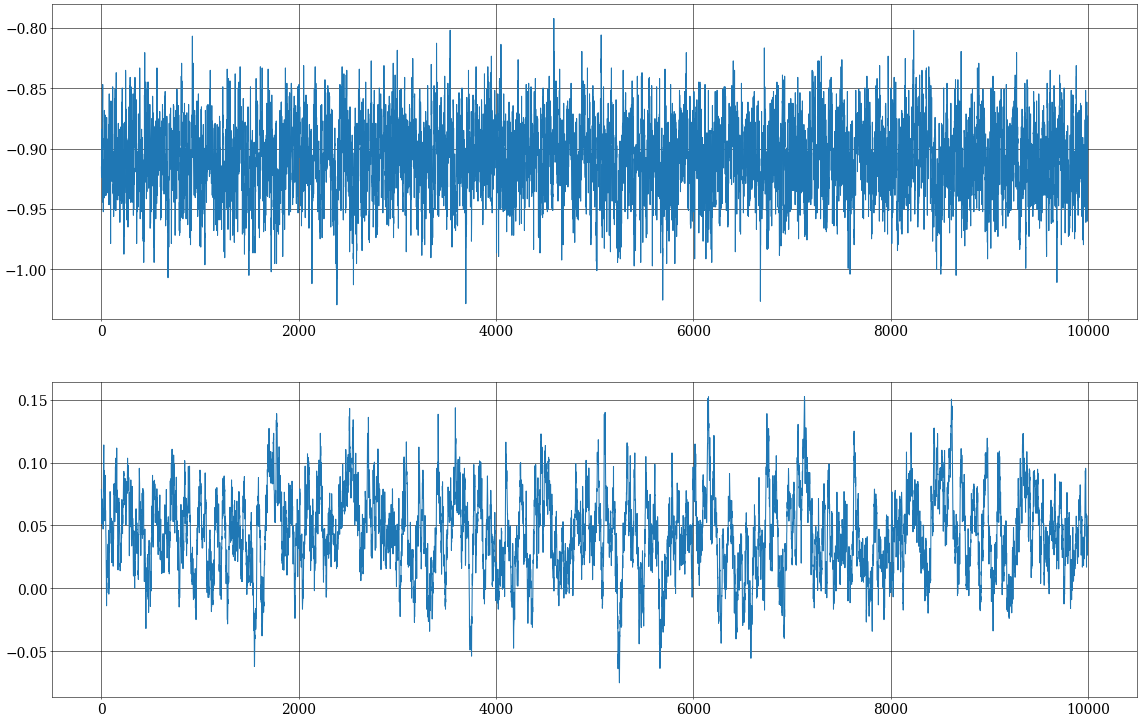

In [48]:
T=2.8
beta = 1 / T
L = 64
dE = np.array([4, 8])  # únicos Delta_E positivos
prob = np.exp(-beta * dE)
S0 = [np.ones((L, L), dtype=int), 2*np.random.randint(2,size=(L,L))-1]
N = 10_000
if type(S0) == list:
    if T < 2.27:
        S = S0[0] #T bajas
    else:
        S = S0[1] #T altas
else:
    S = S0

S = getStermalized(S, prob)
E, M = doNstepsofSimulation(S,N,prob)
plt.subplot(2,1,1)
plt.plot(E)
plt.subplot(2,1,2)
plt.plot(M)

In [51]:
L = 64  # Dimensiones de la red

T_arr = create_dense_domain_around_tc(2.27, 50)
mean_E_T = np.zeros(len(T_arr))
mean_M_T = np.zeros(len(T_arr))
var_E_T = np.zeros(len(T_arr))
var_M_T = np.zeros(len(T_arr))

In [52]:
samples = 50_000
T_threshold = 2.27

T = T_arr[0]
S0 = [np.ones((L, L), dtype=int), 2*np.random.randint(2,size=(L,L))-1]
if T < T_threshold:
    S = S0[0] #T bajas
else:
    S = S0[1] #T altas

for i, T in tqdm(enumerate(T_arr)):
    n_stable = int(pd.read_csv('LT_matrix.csv', index_col='Unnamed: 0')[str(L)].to_numpy()[i])
    mean_E, mean_M, var_E, var_M, S = phase_transition(T, samples, n_stable, S)
    mean_E_T[i] = mean_E
    mean_M_T[i] = mean_M
    var_E_T[i] = var_E
    var_M_T[i] = var_M

0it [00:00, ?it/s]

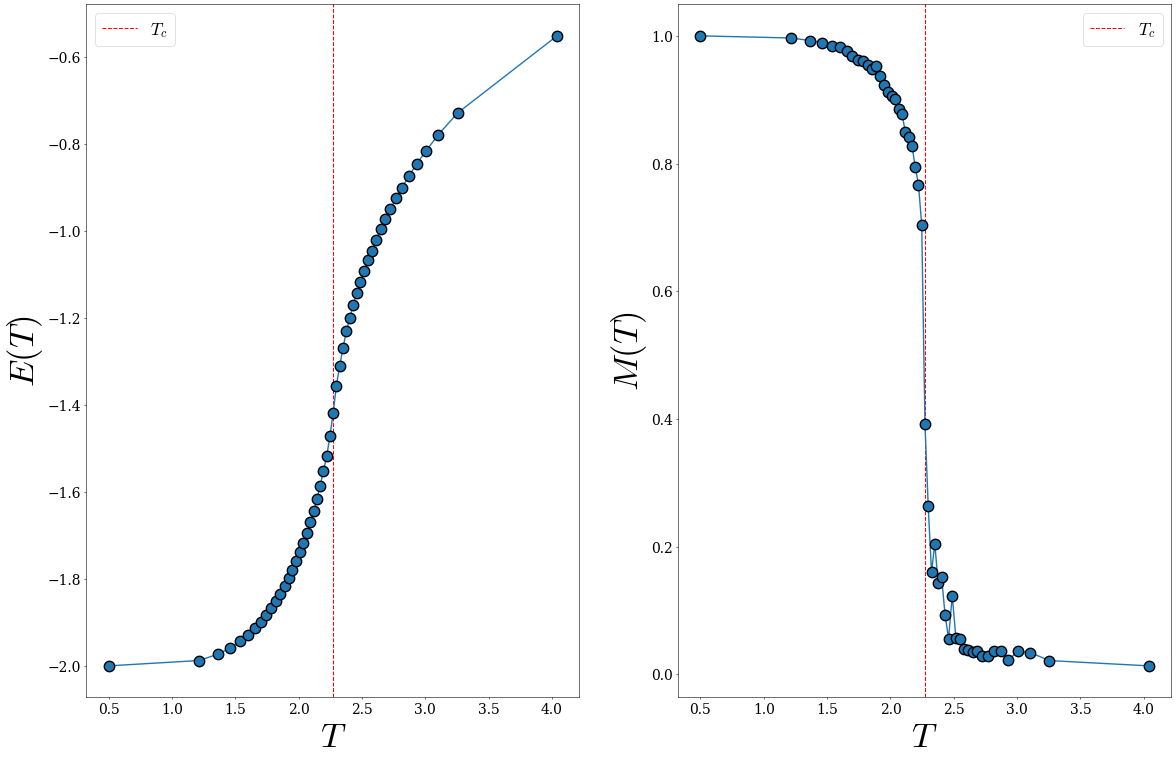

In [42]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_E_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$E(T)$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, mean_M_T, '-o', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$M(T)$')
plt.grid()
plt.legend()
plt.show()

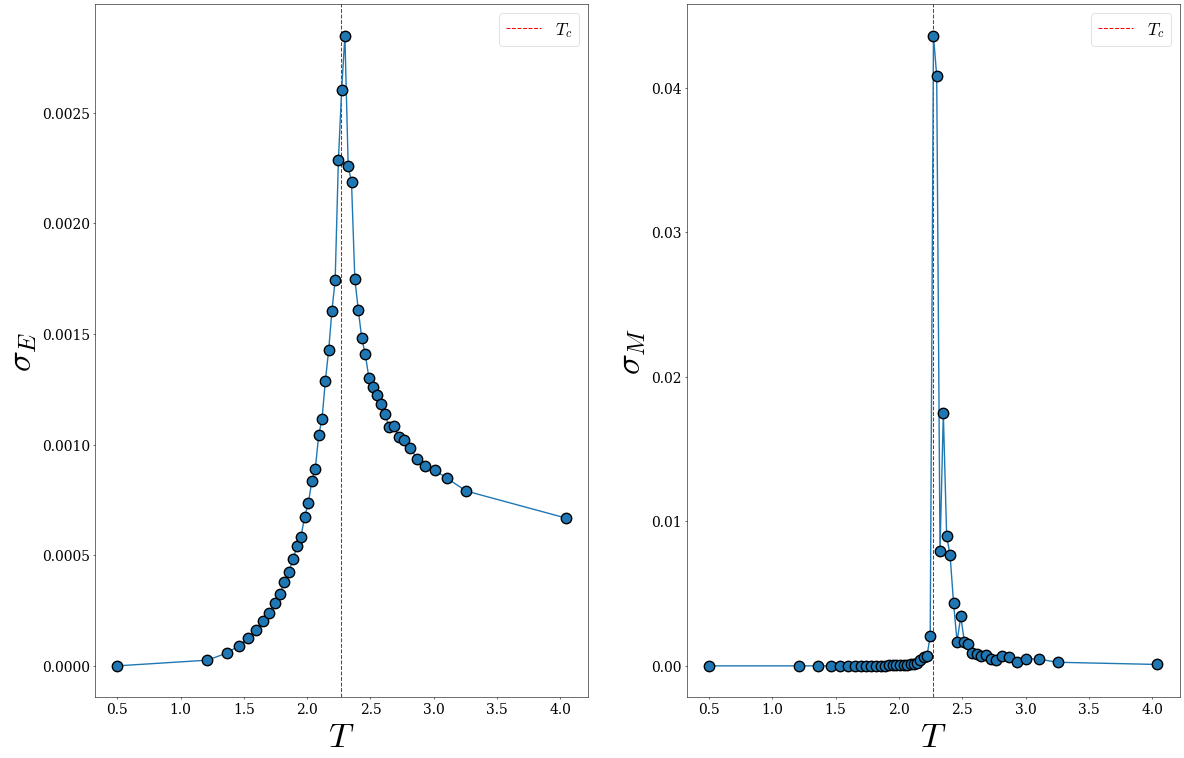

In [43]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel('$\sigma_E$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\sigma_M$')
plt.legend()
plt.grid()
plt.show()

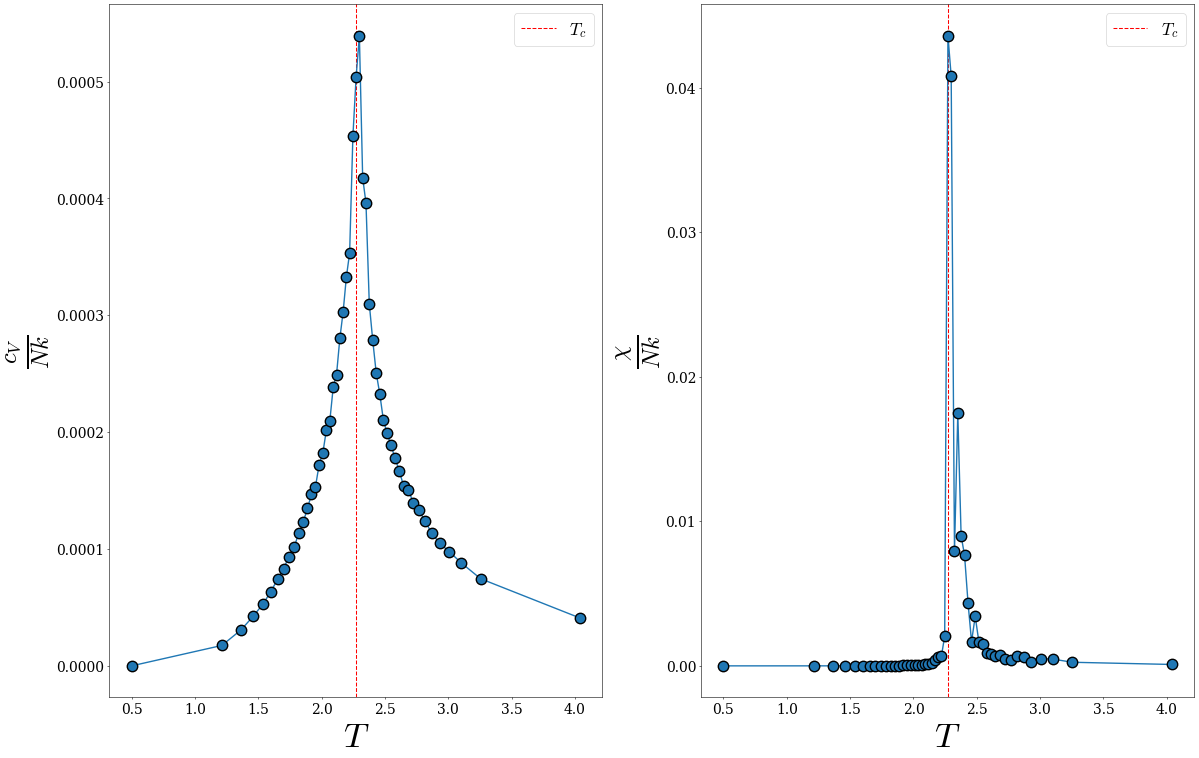

In [44]:
plt.subplot(1, 2, 1)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_E_T*(1/T_arr**2), 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{c_V}{Nk}$')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.axvline(2.27,color='r',ls='--',label='$T_c$')
plt.plot(T_arr, var_M_T, 'o-', lw = 2, markersize = 15, mec = 'black', mew = 2)
plt.xlabel('$T$')
plt.ylabel(r'$\frac{\chi}{Nk}$')
plt.grid()
plt.legend()
plt.show()

# Punto 4: Correlaciones

In [23]:
@njit
def cor(S: np.ndarray) -> np.ndarray:
    L = S.shape[0]
    cor_vec = np.zeros(L // 2)
    for r, _ in enumerate(cor_vec):
        cor_filas = np.zeros(L)
        for i in prange(L):
            fila = S[i]
            fila_shift = np.roll(fila, r)
            cor_filas[i] = np.sum(fila * fila_shift)
        cor_vec[r] = np.sum(cor_filas)
    return cor_vec / (L**2)


@njit
def metropolis2(S: np.ndarray, prob: np.ndarray):
    # Aplica el algoritmo de Metropolis al estado S
    # if N == S.size:
    #    return S, h(S), np.mean(S)
    dm = 0
    dc = np.zeros(S.shape[0] // 2)
    for _ in range(S.size):
        i, j = np.random.choice(
            S.shape[0], 2
        )  # Elegimos 2 posiciones al azar en el rango [0,L)
        sij = S[i, j]  # Obtenemos el spin de esa posición
        opp_sij = -sij  # Obtenemos el spin opuesto al original
        # dE_sij = calculate_dE(opp_sij, i, j, S) - calculate_dE(
        #     sij, i, j, S
        # )
        dE_sij = calculate_dE(sij, i, j, S)
        # La diferencia de energía entre tener el spin opuesto y tener el actual
        p = np.random.random(1)
        c_viejo = cor(S)  # [Optim] Levantar de cuenta anterior?
        if (
            dE_sij <= 0
            or (dE_sij == 4 and p < prob[0])
            or (dE_sij == 8 and p < prob[1])
        ):
            S[i, j] = opp_sij
            dm += opp_sij
            dc += cor(S) - c_viejo  # [Optim] Se podría calcular la contribución especifica de este spin
    # La consigna dice que hay que aplicar el algoritmo de metrópolis por cada sitio en
    # la red, es decir, L cuadrado veces.
    # return metropolis(S, prob, N + 1)
    return S, dm / S.size, dc / S.size

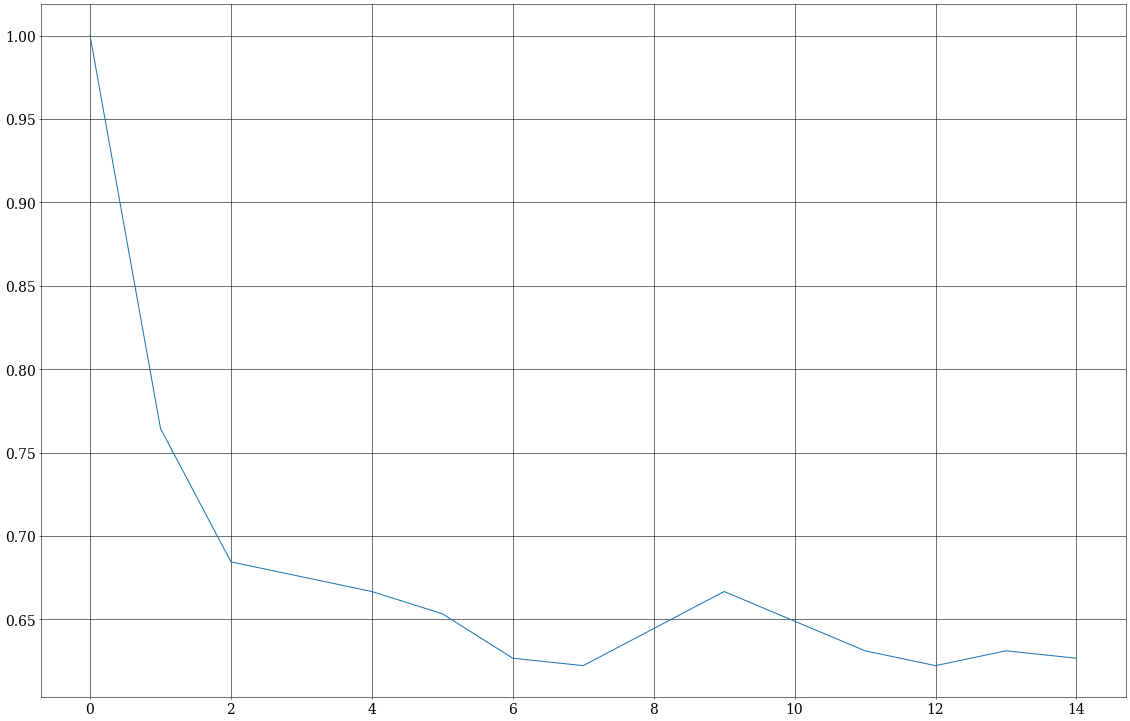

In [24]:
plt.plot(cor(S))
plt.show()

In [25]:
L = 30

nequilibrio = 1_000
npromedio = 500

l = L // 2  # numero de componentes del vector c
m = np.zeros(npromedio)  # magnetizacion en funcion del paso
c = np.zeros((l, npromedio))  # vector c en funcion del paso

r_vals = np.arange(l)  # dominio de la funcion de correlacion


def fitcor(r, a, xi):  # funcion con la que vamos a ajustar
    return a * np.exp(-r / xi)


S = np.ones((L, L), dtype=int)

print("Longitud de correlacion:")

for T in tqdm([1.5, 2.3, 3], desc="Temperaturas"):

    beta = 1 / T

    prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

    # Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in tqdm(range(nequilibrio), desc="Termalizando"):
        S, dm, de = metropolis(S, prob)

    m[0] = np.mean(S)
    c[:, 0] = cor(S)

    for n in tqdm(range(1, npromedio), desc="Midiendo"):
        S, dm, dc = metropolis2(S, prob)
        m[n] = m[n - 1] + dm
        c[:, n] = c[:, n - 1] + dc

    mmedia = np.mean(abs(m))
    correlacion = np.mean(c, axis=1) - mmedia**2  # funcion de correlacion

    # Ajustamos:
    parametros, covarianza = curve_fit(fitcor, r_vals, correlacion)
    # (la funcion curve_fit devuelve el mejor valor de los parametros
    # y tambien la covarianza, que no vamos a usar)

    print("T={} => {}".format(T, parametros[1]))

    plt.plot(r_vals, fitcor(r_vals, parametros[0], parametros[1]), label="T={}".format(T))

plt.xlabel("r")
plt.ylabel("funcion de correlacion")
plt.legend()
plt.show()

Longitud de correlacion:


Temperaturas:   0%|          | 0/3 [00:00<?, ?it/s]

Termalizando:   0%|          | 0/1000 [00:00<?, ?it/s]

Midiendo:   0%|          | 0/499 [00:00<?, ?it/s]

SystemError: CPUDispatcher(<function metropolis2 at 0x74947e726c00>) returned a result with an exception set